# Vascular age - example

## Setup

### Import libraries

- The 'WFDB' toolbox provides tools for reading data from 'WaveForm DataBase' format (which is the format used on [PhysioNet](https://physionet.org/))
- The 'Neurokit2' toolbox provides tools for physiological signal processing

In [ ]:
! pip install wfdb
! pip install neurokit2

In [51]:
import neurokit2 as nk2
import wfdb

<div class="alert alert-block alert-info">
<p><b>Q:</b> Can you find out more about these packages? What is the 'Waveform DataBase Format', and what tasks could 'Neurokit' be used for? <br> <b>Hint:</b> See <a href="https://wfdb.readthedocs.io/">the WFDB documentation</a>, and the <a href="https://neuropsychology.github.io/NeuroKit/">the Neurokit documentation</a>.</p>
</div>

- The following toolboxes are often used in data science, and provide tools for data analysis

In [52]:
import numpy as np
from scipy import signal
from statistics import median
import matplotlib.pyplot as plt

### Setup database

- Specify the name of the database on PhysioNet ([here](https://physionet.org/content/pulse-transit-time-ppg/1.1.0/)).

In [53]:
database_name = 'pulse-transit-time-ppg/1.1.0' # The name of the database on Physionet

<div class="alert alert-block alert-info">
<p><b>Q:</b> Do look into <a href="https://physionet.org/">PhysioNet</a> and the <a href="https://physionet.org/about/database/">datasets it hosts</a>.</p>
</div>

- Find a list of records in the database

In [54]:
record_list = wfdb.get_record_list(database_name)

# Output the result
print(f"The '{database_name}' database contains {len(record_list)} records")

The 'pulse-transit-time-ppg/1.1.0' database contains 66 records


### Import required functions

The following functions have been written to perform tasks specifically for this analysis.

It's help to appreciate what the functions do (as described in the bullet points), and to be aware of the inputs to the functions (which are provided in the brackets on the first line of the function).

- This function finds suitable records in the database. It finds records which meet the following criteria:
  - `required_signals`: Contain the required signals
  - `required_duration`: Are of at least the required duration
  - `required_activity`: Were collected during the required activity

In [55]:
def find_suitable_records(required_signals, required_duration, required_activity, do_verbose=False):
    """
    Description: Finds suitable records in the Pulse Transit Time PPG dataset.
    """    
    
    matching_recs = {'dir':[], 'name':[], 'length':[], 'start_sbp':[], 'end_sbp':[], 'delta_sbp':[], 'age':[]}

    for record in record_list:
        if do_verbose:
            print('Record: {}'.format(record), end="", flush=True)
    
        # check whether this record corresponds to a suitable activity
        if not required_activity in record:
            if do_verbose:
                print('   (not required activity)')
            continue

        record_data = wfdb.rdheader(record,
                                    pn_dir=database_name,
                                    rd_segments=True)

        # Check whether the required signals are present in the record
        sigs_present = record_data.sig_name
        if not all(x in sigs_present for x in required_signals):
            if do_verbose:
                print('   (missing signals)')
            continue

        seg_length = record_data.sig_len/(record_data.fs)

        if seg_length < required_duration:
            if do_verbose:
                print(f' (too short at {seg_length/60:.1f} mins)')
            continue
    
        # This record does meet the requirements, so extract information and data from it
    
        # Information
        matching_recs['dir'].append(database_name)
        matching_recs['name'].append(record_data.record_name)
        matching_recs['length'].append(seg_length)
    
        # Blood pressure measurements
        str_to_find = '<bp_sys_start>: '
        curr_len = len(str_to_find)
        start_el = record_data.comments[0].index(str_to_find) + curr_len
        str_to_find = '<bp_sys_end>'
        end_el = record_data.comments[0].index(str_to_find) - 1
        matching_recs['start_sbp'].append(int(record_data.comments[0][start_el:end_el]))
        str_to_find = '<bp_sys_end>: '
        curr_len = len(str_to_find)
        start_el = record_data.comments[0].index(str_to_find) + curr_len
        str_to_find = '<bp_dia_start>'
        end_el = record_data.comments[0].index(str_to_find) - 1
        matching_recs['end_sbp'].append(int(record_data.comments[0][start_el:end_el]))
        matching_recs['delta_sbp'].append(matching_recs['end_sbp'][-1]-matching_recs['start_sbp'][-1])

        # ages
        str_to_find = '<age>: '
        curr_len = len(str_to_find)
        start_el = record_data.comments[0].index(str_to_find) + curr_len
        str_to_find = '<bp_sys_start>'
        end_el = record_data.comments[0].index(str_to_find) - 1
        matching_recs['age'].append(float(record_data.comments[0][start_el:end_el]))

        if do_verbose:
            print('   (met requirements)')
    
    if do_verbose:
        print(f"A total of {len(matching_recs['dir'])} out of {len(record_list)} records met the requirements.")
    
    return matching_recs

- This function extracts a short segment of data from a longer record. It uses the following inputs:
  - `start_seconds`: the start time at which to start extracting data.
  - `n_seconds_to_load`: the duration of the segment to be extracted.
  - `record_name`: the name of the record from which data are to be extracted.
  - `record_dir`: the folder (a.k.a directory) which contains the record.
  - `required_signals`: the signals to be extracted.

In [56]:
def extract_segment_of_data(start_seconds, n_seconds_to_load, record_name, record_dir, required_signals, do_verbose=False):

    # Get sampling frequency from header data
    record_data = wfdb.rdheader(record_name,
                                pn_dir=record_dir,
                                rd_segments=True)
    fs = record_data.fs
    
    # Specify timings of segment to be extracted
    sampfrom = fs * start_seconds
    sampto = fs * (start_seconds + n_seconds_to_load)

    # Load segment data
    segment_data = wfdb.rdrecord(record_name=record_name,
                                 channel_names = required_signals,
                                 sampfrom=sampfrom,
                                 sampto=sampto,
                                 pn_dir=record_dir)

    if do_verbose:
        print(f"{n_seconds_to_load} seconds of data extracted from record: {record_name}")
    
    return segment_data

- This function finds peaks in PPG signal. It takes the following inputs:
  - `raw`: raw PPG signal
  - `fs`: sampling frequency (in Hz)

In [57]:
def get_ppg_peaks(raw, fs):
  ppg_clean = nk2.ppg_clean(raw, sampling_rate=fs)
  peaks = nk2.ppg_findpeaks(ppg_clean, method="elgendi", show=False)  
  return peaks['PPG_Peaks']

- This function finds peaks in an ECG signal. It takes the following inputs:
  - `raw`: raw ECG signal
  - `fs`: sampling frequency (in Hz)

In [58]:
def get_ecg_peaks(raw, fs):
    ecg_clean = nk2.ecg_clean(raw, sampling_rate=fs)
    signals, info = nk2.ecg_peaks(ecg_clean, method="neurokit", show=False)  
    peaks = info["ECG_R_Peaks"]
    return peaks

- This function finds PPG pulse onsets as the minimum values between each pair of identified PPG peaks. It takes the following inputs:
  - `ppg`: A PPG signal
  - `pks`: the peaks in a PPG signal
  - `fs`: the sampling frequency (in Hz)

In [59]:
def get_ppg_onsets(ppg, pks, fs):
    ons = np.empty(0)
    for i in range(len(pks) - 1):
        start = pks[i]
        stop = pks[i + 1]
        ibi = ppg[start:stop]
        aux_ons = np.argmin(ibi)
        # aux_ons, = np.where(ibi == np.min(ibi))
        ind_ons = aux_ons.astype(int)
        ons = np.append(ons, ind_ons + start)   

    ons = ons.astype(int)
    return ons

- A function to find the index in a list which immediately follows a specified point. It takes the following inputs:
  - `array`: the list of sample numbers (e.g. a list of PPG peak sample numbers)
  - `value`: the sample number of the specified point (e.g. an ECG R-wave sample number)

In [60]:
def find_next(array, value):
    array = np.asarray(array)
    diffs = array - value
    diffs = np.where(diffs>0, diffs, 100000)
    idx = diffs.argmin()
    return array[idx]

# Extracting a dataset

## Finding suitable records in the database

- Specify the required signals

In [61]:
name_of_ecg_signal = "ecg" # the name of the ecg signal in the data
name_of_ppg_signal = "pleth_1" # the name of the ppg signal in the data
required_signals = [name_of_ecg_signal, name_of_ppg_signal]

<div class="alert alert-block alert-info">
<p><b>Q:</b> Can you find out the details of the 'pleth_1' signal from the <a href="https://physionet.org/content/pulse-transit-time-ppg/1.1.0/">database description</a>? How was it measured? Is it ieal for vascular ageing assessment? What alternative signals are available?</p>
</div>

- Specify the required duration in seconds

In [62]:
required_duration = 1*60 # in seconds

- Specify the required activity

In [63]:
required_activity = "sit"

<div class="alert alert-block alert-info">
<p><b>Q:</b> Similarly, can you find out what different activities the data in this database were collected during? See the <a href="https://physionet.org/content/pulse-transit-time-ppg/1.1.0/">database description</a>.</p>
</div>

- find records which meet these requirements

In [64]:
do_verbose = True # this tells the function to output some text to explain what it is doing.
matching_recs = find_suitable_records(required_signals, required_duration, required_activity, do_verbose)

Record: s1_walk   (not required activity)
Record: s1_run   (not required activity)
Record: s1_sit   (met requirements)
Record: s2_walk   (not required activity)
Record: s2_run   (not required activity)
Record: s2_sit   (met requirements)
Record: s3_sit   (met requirements)
Record: s3_walk   (not required activity)
Record: s3_run   (not required activity)
Record: s4_sit   (met requirements)
Record: s4_run   (not required activity)
Record: s4_walk   (not required activity)
Record: s5_walk   (not required activity)
Record: s5_run   (not required activity)
Record: s5_sit   (met requirements)
Record: s6_run   (not required activity)
Record: s6_sit   (met requirements)
Record: s6_walk   (not required activity)
Record: s7_walk   (not required activity)
Record: s7_run   (not required activity)
Record: s7_sit   (met requirements)
Record: s8_sit   (met requirements)
Record: s8_run   (not required activity)
Record: s8_walk   (not required activity)
Record: s9_walk   (not required activity)
Record

## Extract data from a record

- specify details of the segment of data to be extracted

In [65]:
start_seconds = 0
n_seconds_to_load = 60
subj_no = 0  # In python, zero refers to the first item in a list
record_name = matching_recs['name'][subj_no]
record_dir = matching_recs['dir'][subj_no]

- extract this segment of data

In [66]:
do_verbose = True
segment_data = extract_segment_of_data(start_seconds, n_seconds_to_load, record_name, record_dir, required_signals, do_verbose)

60 seconds of data extracted from record: s1_sit


# Signal processing

## Extract signals

- Extract PPG and ECG signals from the segment of data

In [67]:
sig_list = ["ppg", "ecg"] # a list of signals to be extracted
for sig in sig_list:  # cycle through each signal in the list
    exec("curr_sig_name = name_of_" + sig + "_signal")  # specify the name of the signal
    rel_col = segment_data.sig_name.index(curr_sig_name)  # identify the column in the data which contains this signal
    exec(sig + " = segment_data.p_signal[:,rel_col]")  # extract the data for this signal

- Extract sampling frequency

In [68]:
fs = segment_data.fs

## Invert PPG signal

This is usually done to make the PPG signal look like a blood pressure signal. Consider why this is the case.

In [69]:
ppg = -1*ppg

## Filter signals

Signals are filtered to eliminate noise from the signals, which makes it easier for the signal processing to perform well.

- Filter PPG

In [70]:
ppg = nk2.ppg_clean(ppg, sampling_rate=fs)

<div class="alert alert-block alert-info">
<p><b>Info:</b> You can find out more about this function <a href="https://neuropsychology.github.io/NeuroKit/functions/ppg.html#neurokit2.ppg.ppg_clean">here</a>.</p>
</div>

- Filter ECG

In [71]:
ecg = nk2.ecg_clean(ecg, sampling_rate=fs)

<div class="alert alert-block alert-info">
<p><b>Q:</b> You can find out more about this function <a href="https://neuropsychology.github.io/NeuroKit/functions/ecg.html#ecg-clean">here</a>. What frequency content does it exclude from the signal?</p>
</div>

## Beat detection

The next step is to detect beats in the signals

### PPG beat detection

- Detect beats

In [72]:
ppg_peaks = get_ppg_peaks(ppg, fs)

- Plot results

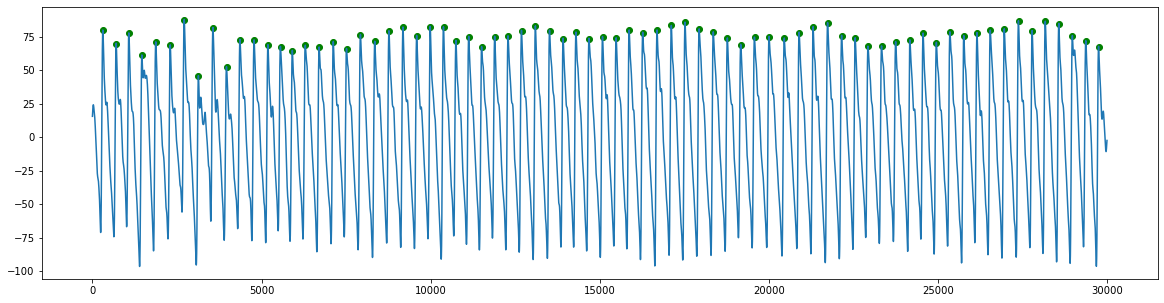

In [73]:
plt.figure(figsize=(20,5))  # setup the figure
plt.plot(ppg)  # plot the PPG signal
heights = ppg[ppg_peaks]  # extract the heights of the PPG peaks
plt.scatter(ppg_peaks, heights, marker='o', color='green') # plot points indicating the PPG peaks (plot the sample numbers against the heights, using green circular markers)
plt.show()

### ECG beat detection

- Detect beats

In [74]:
ecg_peaks = get_ecg_peaks(ecg, fs)

- Plot results

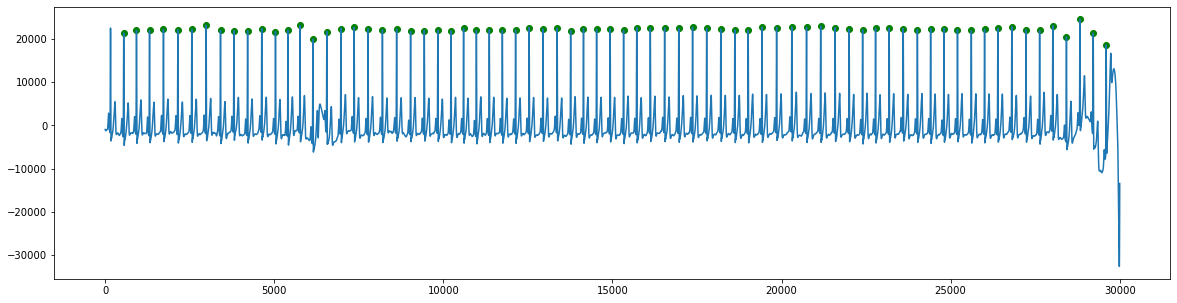

In [75]:
plt.figure(figsize=(20,5))
plt.plot(ecg)
heights = ecg[ecg_peaks]
plt.scatter(ecg_peaks, heights, marker='o', color='green')
plt.show()

## Extract timings

### ECG timings

The ECG timings are simply the times of the R-waves, which indicate the times of ventricular depolarisation (i.e. the electrical activity which prompts ventricular contraction).

In [76]:
ecg_timings = ecg_peaks

### PPG timings

Ideally, we wouldn't use the times of systolic peaks on PPG waves, because there can be a variable delay between the pulse onset and systolic peak. Therefore, we use an alternative, such as the time of pulse onset:

- Getting the times of PPG pulse wave onsets

In [77]:
ppg_timings = get_ppg_onsets(ppg,ppg_peaks,fs)

- Plotting the results

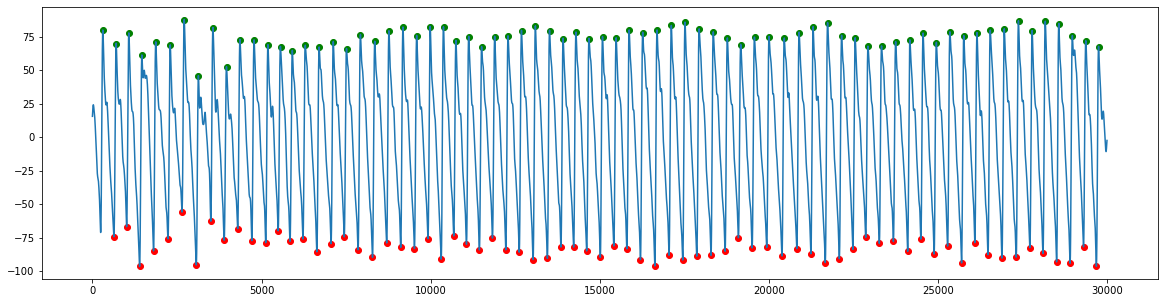

In [78]:
plt.figure(figsize=(20,5))
plt.plot(ppg)
heights_peaks = ppg[ppg_peaks]
heights_onsets = ppg[ppg_timings]
plt.scatter(ppg_peaks, heights_peaks, marker='o', color='green')
plt.scatter(ppg_timings, heights_onsets, marker='o', color='red')
plt.show()

## Extract pulse arrival times

- Find pairs of R-waves and subsequent PPG pulse onsets

In [79]:
rel_ppg_timings = []
for ecg_timing in ecg_timings:
    current_ppg_timing = find_next(ppg_timings, ecg_timing)
    rel_ppg_timings.append(current_ppg_timing)

- Calculate pulse arrival times as the difference between the times of R-waves and subsequent PPG pulse onsets

In [80]:
pats = (rel_ppg_timings - ecg_timings)/fs

# Modelling

## Extract dataset

Extract a dataset of:
- Parameter(s) derived from PPG and ECG signals: pulse arrival time
- Reference parameter(s): age

<div class="alert alert-block alert-info">
<p><b>Q:</b> What alternative reference parameters would be ideal?</p>
</div>

### Setup:

In [81]:
subj_nos = [i for i in range(len(matching_recs['name']))]

### Extract median pulse arrival times

In [82]:
median_pats = []
for subj_no in subj_nos:

    # specify this subject's record name and directory:
    record_name = matching_recs['name'][subj_no]
    record_dir = matching_recs['dir'][subj_no]

    # extract this subject's signals
    segment_data = extract_segment_of_data(start_seconds, n_seconds_to_load, record_name, record_dir, required_signals)
    fs = segment_data.fs
    sig_list = ["ppg", "ecg"]
    for sig in sig_list:
        exec("curr_sig_name = name_of_" + sig + "_signal")
        rel_col = segment_data.sig_name.index(curr_sig_name)
        exec(sig + " = segment_data.p_signal[:,rel_col]")
        
    # invert PPG signal
    ppg = -1*ppg
    
    # filter signals
    ppg = nk2.ppg_clean(ppg, sampling_rate=fs)
    ecg = nk2.ecg_clean(ecg, sampling_rate=fs)
    
    # detect beats in signals
    ecg_peaks = get_ecg_peaks(ecg, fs)
    ppg_peaks = get_ppg_peaks(ppg, fs)
    
    # obtain timings
    ecg_timings = ecg_peaks
    ppg_timings = get_ppg_onsets(ppg,ppg_peaks,fs)
    
    # extract pulse arrival times
    rel_ppg_timings = []
    for ecg_timing in ecg_timings:
        current_ppg_timing = find_next(ppg_timings, ecg_timing)
        rel_ppg_timings.append(current_ppg_timing)
    pats = (rel_ppg_timings - ecg_timings)/fs
    
    # find median pulse arrival time for this subject
    curr_median_pat = median(pats)
    median_pats.append(curr_median_pat)
    
    print(f"Subject no. {subj_no} has median PAT of {median_pats[subj_no]} seconds")

Subject no. 0 has median PAT of 0.172 seconds
Subject no. 1 has median PAT of 0.658 seconds
Subject no. 2 has median PAT of 0.192 seconds
Subject no. 3 has median PAT of 0.162 seconds
Subject no. 4 has median PAT of 0.152 seconds
Subject no. 5 has median PAT of 0.192 seconds
Subject no. 6 has median PAT of 0.15 seconds
Subject no. 7 has median PAT of 0.154 seconds
Subject no. 8 has median PAT of 0.208 seconds
Subject no. 9 has median PAT of 0.18 seconds
Subject no. 10 has median PAT of 0.222 seconds
Subject no. 11 has median PAT of 0.176 seconds
Subject no. 12 has median PAT of 0.154 seconds
Subject no. 13 has median PAT of 0.168 seconds
Subject no. 14 has median PAT of 0.214 seconds
Subject no. 15 has median PAT of 0.184 seconds
Subject no. 16 has median PAT of 0.204 seconds
Subject no. 17 has median PAT of 0.18 seconds
Subject no. 18 has median PAT of 0.17 seconds
Subject no. 19 has median PAT of 0.184 seconds
Subject no. 20 has median PAT of 0.176 seconds
Subject no. 21 has median P

### Extract ages

- Cycle through each subject, extracting its age

In [83]:
ages = []
for subj_no in subj_nos:

    # specify this subject's record name and directory:
    record_name = matching_recs['name'][subj_no]
    record_dir = matching_recs['dir'][subj_no]

    # extract this subject's age
    curr_age = matching_recs['age'][subj_no]
    ages.append(curr_age)

## Inspect dataset

- Plot the ages on the x-axis against median pulse arrival times on the y-axis

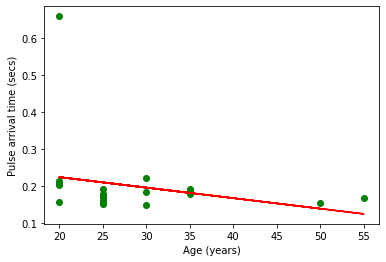

In [84]:
plt.scatter(ages, median_pats, marker='o', color='green')
m, b = np.polyfit(ages, median_pats, 1)
plt.plot(ages, m*np.array(ages)+b, color='red')
plt.xlabel("Age (years)")
plt.ylabel("Pulse arrival time (secs)")
plt.show()

<div class="alert alert-block alert-info">
<p><b>Q:</b> Are there any outliers? Which point(s)?</p>
</div>

- if we exclude the outlier:

In [85]:
rel_ages = []
rel_median_pats = []
for el in range(len(ages)):
    if median_pats[el]<0.3:
        rel_ages.append(ages[el])
        rel_median_pats.append(median_pats[el])

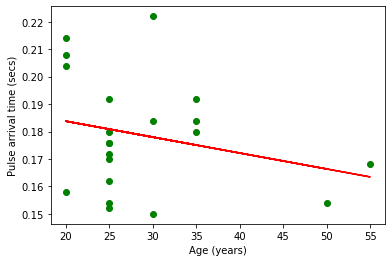

In [86]:
plt.scatter(rel_ages, rel_median_pats, marker='o', color='green')
m, b = np.polyfit(rel_ages, rel_median_pats, 1)
plt.plot(rel_ages, m*np.array(rel_ages)+b, color='red')
plt.xlabel("Age (years)")
plt.ylabel("Pulse arrival time (secs)")
plt.show()

## Taking it further

<div class="alert alert-block alert-info">
<p><b>Q:</b> Can you assess the strength of the correlation? <br> <b>Hint:</b> Consider using the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">'sklearn' package</a></p>
</div>

<div class="alert alert-block alert-info">
<p><b>Q:</b> What other parameters could we extract from the PPG signal? See the <a href="https://peterhcharlton.github.io/bsp-book/tutorials.html">tutorials</a> in this book, and also <a href="https://doi.org/10.1152/ajpheart.00392.2021">this article</a>.</p>
</div>